# First Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\71487\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


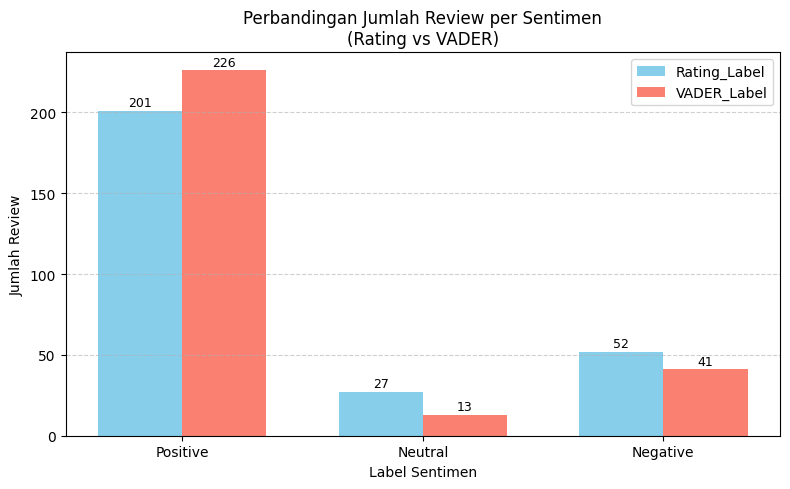

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download lexicon VADER (hanya sekali di awal)
nltk.download('vader_lexicon')

# Step 1: Load dataset
df = pd.read_csv("redmi6.csv", encoding="ISO-8859-1")

# Step 2: Gabungkan review title + comments
df['Full_Review'] = df['Review Title'].astype(str) + " " + df['Comments'].astype(str)

# Step 3: Bersihkan & ubah rating jadi angka
def convert_rating(rating_text):
    try:
        return float(str(rating_text).split()[0])
    except:
        return None

df['Rating_Score'] = df['Rating'].apply(convert_rating)

# Step 4: Buat label dari rating
def rating_to_label(score):
    if pd.isna(score):
        return "Unknown"
    elif score >= 4:
        return "Positive"
    elif score == 3:
        return "Neutral"
    else:
        return "Negative"

df['Rating_Label'] = df['Rating_Score'].apply(rating_to_label)

# Step 5: Analisis VADER
vader = SentimentIntensityAnalyzer()

# Simpan skor compound VADER
df['VADER_Score'] = df['Full_Review'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Konversi skor menjadi label
def vader_to_label(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['VADER_Label'] = df['VADER_Score'].apply(vader_to_label)

# Step 6: Ambil data valid
df_valid = df[(df['Rating_Label'] != "Unknown") & (df['VADER_Label'].notna())]

# Step 7: Hitung jumlah label
labels = ['Positive', 'Neutral', 'Negative']
vader_counts = df_valid['VADER_Label'].value_counts().reindex(labels, fill_value=0)
rating_counts = df_valid['Rating_Label'].value_counts().reindex(labels, fill_value=0)

# Step 8: Side-by-side bar chart
x = range(len(labels))
bar_width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - bar_width/2 for i in x], rating_counts, width=bar_width, label='Rating_Label', color='skyblue')
bars2 = plt.bar([i + bar_width/2 for i in x], vader_counts, width=bar_width, label='VADER_Label', color='salmon')

# Tambahkan angka di atas bar
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, int(bar.get_height()), ha='center', va='bottom', fontsize=9)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, int(bar.get_height()), ha='center', va='bottom', fontsize=9)

plt.title('Perbandingan Jumlah Review per Sentimen\n(Rating vs VADER)')
plt.xticks(ticks=x, labels=labels)
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Review')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

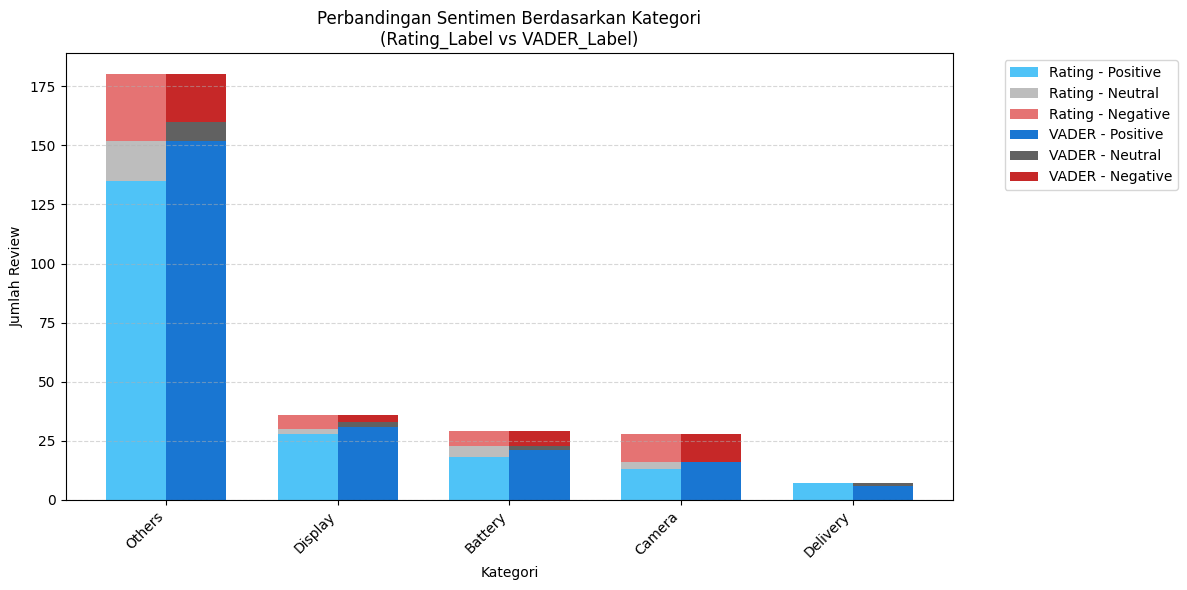

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Asumsikan df sudah ada kolom: Category, Rating_Label, VADER_Label
# Filter data valid
df_valid = df[
    (df['Category'].notna()) &
    (df['Rating_Label'].notna()) &
    (df['Rating_Label'] != "Unknown") &
    (df['VADER_Label'].notna())
]

# Urutkan berdasarkan banyaknya data
top_categories = df_valid['Category'].value_counts().index.tolist()

# Hitung jumlah label per kategori
rating_counts = df_valid.groupby(['Category', 'Rating_Label']).size().unstack(fill_value=0).reindex(top_categories)
vader_counts = df_valid.groupby(['Category', 'VADER_Label']).size().unstack(fill_value=0).reindex(top_categories)

# Label dan warna untuk masing-masing tipe label
labels = ['Positive', 'Neutral', 'Negative']
rating_colors = {'Positive': '#4FC3F7', 'Neutral': '#BDBDBD', 'Negative': '#E57373'}
vader_colors = {'Positive': '#1976D2', 'Neutral': '#616161', 'Negative': '#C62828'}

# Buat bar chart side-by-side
x = range(len(top_categories))
bar_width = 0.35

plt.figure(figsize=(12, 6))

# Bar Rating
for i, label in enumerate(labels):
    if label in rating_counts.columns:
        plt.bar(
            [pos - bar_width/2 for pos in x],
            rating_counts[label],
            width=bar_width,
            bottom=sum(rating_counts[l] for l in labels[:i]) if i > 0 else None,
            color=rating_colors[label],
            label=f'Rating - {label}'
        )

# Bar VADER
for i, label in enumerate(labels):
    if label in vader_counts.columns:
        plt.bar(
            [pos + bar_width/2 for pos in x],
            vader_counts[label],
            width=bar_width,
            bottom=sum(vader_counts[l] for l in labels[:i]) if i > 0 else None,
            color=vader_colors[label],
            label=f'VADER - {label}'
        )

plt.xticks(ticks=x, labels=top_categories, rotation=45, ha='right')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Review')
plt.title('Perbandingan Sentimen Berdasarkan Kategori\n(Rating_Label vs VADER_Label)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Letakkan legend di luar
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# Filter data valid
df_valid = df[
    (df['Category'].notna()) &
    (df['Rating_Label'].notna()) &
    (df['Rating_Label'] != "Unknown") &
    (df['VADER_Label'].notna())
]

# Bandingkan label
df_valid['Match'] = df_valid['Rating_Label'] == df_valid['VADER_Label']

# Hitung total, cocok, tidak cocok per kategori
summary = df_valid.groupby('Category').agg(
    Total=('Match', 'count'),
    Cocok=('Match', 'sum'),
    Tidak_Cocok=('Match', lambda x: (~x).sum())
)

# Hitung akurasi dan error rate
summary['Akurasi (%)'] = (summary['Cocok'] / summary['Total'] * 100).round(2)
summary['Error Rate (%)'] = (summary['Tidak_Cocok'] / summary['Total'] * 100).round(2)

# Tambahkan distribusi label
label_dist = df_valid.groupby('Category')['Rating_Label'].value_counts().unstack(fill_value=0)
summary = summary.join(label_dist)

# Urutkan berdasarkan error tertinggi (atau bisa berdasarkan akurasi juga)
summary = summary.sort_values('Error Rate (%)', ascending=False)

# Tampilkan
print(summary.reset_index())



   Category  Total  Cocok  Tidak_Cocok  Akurasi (%)  Error Rate (%)  Negative  \
0   Battery     29     22            7        75.86           24.14         6   
1    Camera     28     22            6        78.57           21.43        12   
2    Others    180    145           35        80.56           19.44        28   
3  Delivery      7      6            1        85.71           14.29         0   
4   Display     36     31            5        86.11           13.89         6   

   Neutral  Positive  
0        5        18  
1        3        13  
2       17       135  
3        0         7  
4        2        28  


# Second Analysis

In [61]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download leksikon VADER jika belum
nltk.download('vader_lexicon')

# Load dataset
df = pd.read_csv("redmi6.csv", encoding="ISO-8859-1")

# Gabungkan review title dan comments
df['Full_Review'] = df['Review Title'].astype(str) + " " + df['Comments'].astype(str)

# Konversi rating menjadi angka
def convert_rating(rating_text):
    try:
        return float(str(rating_text).split()[0])
    except:
        return None

df['Rating_Score'] = df['Rating'].apply(convert_rating)

# Label dari rating
def rating_to_label(score):
    if pd.isna(score):
        return "Unknown"
    elif score >= 4:
        return "Positive"
    elif score == 3:
        return "Neutral"
    else:
        return "Negative"

df['Rating_Label'] = df['Rating_Score'].apply(rating_to_label)

# --- VADER Analysis ---
vader = SentimentIntensityAnalyzer()
df['VADER_Score'] = df['Full_Review'].apply(lambda x: vader.polarity_scores(str(x))['compound'])

def vader_to_label(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['VADER_Label'] = df['VADER_Score'].apply(vader_to_label)

# # --- Refined Category dari "Others" ---
df['Review_Lower'] = df['Full_Review'].str.lower()

# def revise_category(row):
#     if row['Category'] != 'Others':
#         return row['Category']
#     review = row['Review_Lower']
#     if "camera" in review:
#         return "Camera"
#     elif "battery" in review:
#         return "Battery"
#     elif "display" in review or "screen" in review:
#         return "Display"
#     elif "delivery" in review or "courier" in review:
#         return "Delivery"
#     elif "price" in review or "value" in review:
#         return "Pricing"
#     else:
#         return "Others"

# df['Revised_Category'] = df.apply(revise_category, axis=1)

# --- Label Koreksi Manual untuk Neutral Rating ---
def correct_neutral_label(row):
    if row['Rating_Label'] != 'Neutral':
        return row['VADER_Label']
    if any(word in row['Review_Lower'] for word in ["but", "however", "although", "though", "yet", "still"]):
        return "Neutral"  # Tetap netral (tapi bisa dianalisis terpisah)
    else:
        return "Neutral"

df['New_Label'] = df.apply(correct_neutral_label, axis=1)

# # Tampilkan hasil awal untuk rating neutral
# df_neutral = df[df['Rating_Label'] == 'Neutral'][[
#     'Full_Review', 'Category', 'Revised_Category', 'Rating_Label', 'New_Label', 'VADER_Label', 'VADER_Score'
# ]]
print(df.head(10))



                                        Review Title  \
0       Another Midrange killer Smartphone by Xiaomi   
1                              vry small size mobile   
2       Full display not working in all application.   
3                                    Value for Money   
4                            Not worth for the money   
5  Redmi 6 pro (3/32 GB) review after using for o...   
6                                          Fabulous!   
7                                          Fantastic   
8                                               Good   
9                             All youtubers are paid   

              Customer name              Rating                  Date  \
0         Rishikumar Thakur  4.0 out of 5 stars     on 1 October 2018   
1                   Raza ji  3.0 out of 5 stars  on 15 September 2018   
2             Vaibhav Patel  3.0 out of 5 stars  on 18 September 2018   
3           Amazon Customer  5.0 out of 5 stars  on 28 September 2018   
4  Sudhakaran Wada

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\71487\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [62]:
df

,Review Title,Customer name,Rating,Date,Category,Comments,Useful,Full_Review,Rating_Score,Rating_Label,VADER_Score,VADER_Label,Review_Lower,New_Label
0,Another Midrange killer Smartphone by Xiaomi,Rishikumar Thakur,4.0 out of 5 stars,on 1 October 2018,Display,Another Midrange killer Smartphone by Xiaomi\n...,,Another Midrange killer Smartphone by Xiaomi A...,4.0,Positive,0.9980,Positive,another midrange killer smartphone by xiaomi a...,Positive
1,vry small size mobile,Raza ji,3.0 out of 5 stars,on 15 September 2018,Others,All ok but vry small size mobile,7 people found this helpful,vry small size mobile All ok but vry small siz...,3.0,Neutral,0.1531,Positive,vry small size mobile all ok but vry small siz...,Neutral
2,Full display not working in all application.,Vaibhav Patel,3.0 out of 5 stars,on 18 September 2018,Others,Quite good,7 people found this helpful,Full display not working in all application. Q...,3.0,Neutral,0.4927,Positive,full display not working in all application. q...,Neutral
3,Value for Money,Amazon Customer,5.0 out of 5 stars,on 28 September 2018,Display,Redmi has always have been the the king of bud...,2 people found this helpful,Value for Money Redmi has always have been the...,5.0,Positive,0.9677,Positive,value for money redmi has always have been the...,Positive
4,Not worth for the money,Sudhakaran Wadakkancheri,2.0 out of 5 stars,on 18 September 2018,Others,worst product from MI. I am a hardcore fan of ...,6 people found this helpful,Not worth for the money worst product from MI....,2.0,Negative,-0.7889,Negative,not worth for the money worst product from mi....,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,"Cemera quality,face unlock most important in t...",Rahul,5.0 out of 5 stars,on 19 September 2018,Others,"I like This Phone, Awesome look and design.\nI...",NaN,"Cemera quality,face unlock most important in t...",5.0,Positive,0.8268,Positive,"cemera quality,face unlock most important in t...",Positive
276,Mi is best phone,Sunil Soni,4.0 out of 5 stars,on 18 September 2018,Others,Product is avasome but invoice is note include...,NaN,Mi is best phone Product is avasome but invoic...,4.0,Positive,0.3818,Positive,mi is best phone product is avasome but invoic...,Positive
277,Its a OK Phone,D.C.Padhi,3.0 out of 5 stars,on 15 September 2018,Battery,"Redmi Note4, Note5, now 6pro..It seems the old...",NaN,"Its a OK Phone Redmi Note4, Note5, now 6pro..I...",3.0,Neutral,0.4592,Positive,"its a ok phone redmi note4, note5, now 6pro..i...",Neutral
278,Redmi,Mahesh,5.0 out of 5 stars,on 21 September 2018,Others,I love mi,NaN,Redmi I love mi,5.0,Positive,0.6369,Positive,redmi i love mi,Positive


   Category  Total  Cocok  Tidak_Cocok  Akurasi
0   Battery     29     27            2    93.10
1   Display     36     33            3    91.67
2    Others    180    161           19    89.44
3    Camera     28     25            3    89.29
4  Delivery      7      6            1    85.71


C:\Users\71487\AppData\Local\Temp\ipykernel_19744\702869055.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


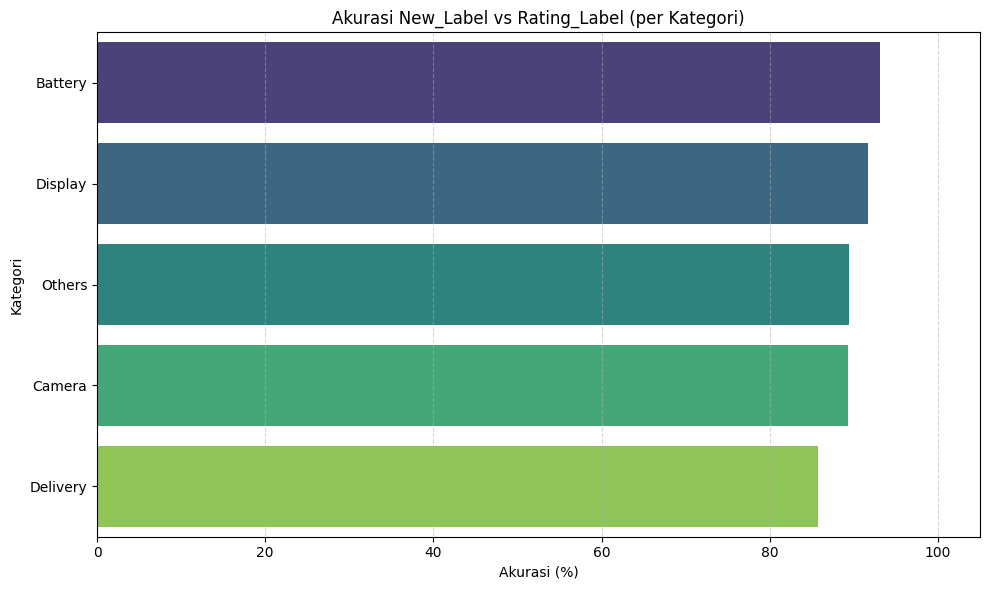

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung akurasi New_Label vs Rating_Label per kategori
summary = df[
    (df['New_Label'].notna()) &
    (df['Rating_Label'].notna()) &
    (df['Rating_Label'] != "Unknown")
].groupby('Category').agg(
    Total=('New_Label', 'count'),
    Cocok=('New_Label', lambda x: (x == df.loc[x.index, 'Rating_Label']).sum()),
    Tidak_Cocok=('New_Label', lambda x: (x != df.loc[x.index, 'Rating_Label']).sum())
)

# Hitung akurasi
summary['Akurasi'] = (summary['Cocok'] / summary['Total'] * 100).round(2)

# Reset index untuk visualisasi
summary_sorted = summary.sort_values('Akurasi', ascending=False).reset_index()
print(summary_sorted)
# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_sorted,
    x='Akurasi',
    y='Category',
    palette='viridis'
)
plt.title('Akurasi New_Label vs Rating_Label (per Kategori)')
plt.xlabel('Akurasi (%)')
plt.ylabel('Kategori')
plt.xlim(0, 105)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Training NLP 

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Step 1: Ambil data dengan kategori yang bukan Others sebagai data latih
# df_train = df[df['Category'] != 'Others'].copy()
df_train = df.copy()

# Step 2: Siapkan X dan y
X_train = df_train['Full_Review']
y_train = df_train['Category']

# Step 3: Buat pipeline NLP model (TF-IDF + Logistic Regression)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', lowercase=True, max_features=3000)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Step 4: Training model
text_clf.fit(X_train, y_train)

# Step 5: Prediksi semua data (termasuk Others)
df['Revised_Category_NLP'] = text_clf.predict(df['Full_Review'])


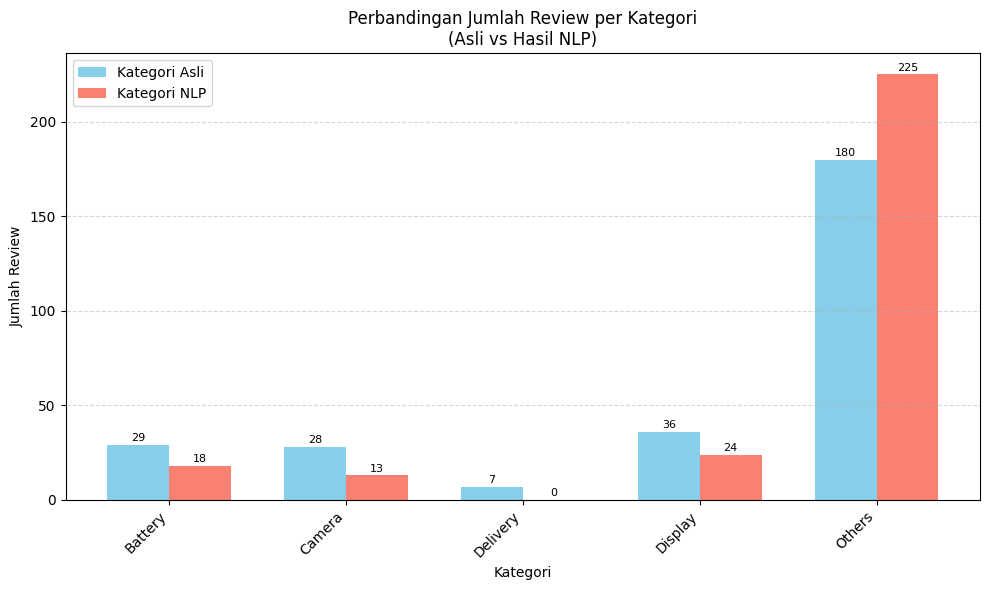

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung jumlah untuk kategori asli
original_counts = df['Category'].value_counts().sort_index()
# Hitung jumlah untuk kategori hasil prediksi NLP
revised_counts = df['Revised_Category_NLP'].value_counts().sort_index()

# Gabungkan jadi satu DataFrame
compare_df = pd.DataFrame({
    'Kategori Asli': original_counts,
    'Kategori NLP': revised_counts
}).fillna(0).astype(int)

# Sort berdasarkan kategori (index)
compare_df = compare_df.sort_index()

# Plot side-by-side
plt.figure(figsize=(10, 6))
x = range(len(compare_df))
bar_width = 0.35

plt.bar([i - bar_width/2 for i in x], compare_df['Kategori Asli'], width=bar_width, label='Kategori Asli', color='skyblue')
plt.bar([i + bar_width/2 for i in x], compare_df['Kategori NLP'], width=bar_width, label='Kategori NLP', color='salmon')

# Tambahkan label bar
for i, val in enumerate(compare_df['Kategori Asli']):
    plt.text(i - bar_width/2, val + 1, str(val), ha='center', va='bottom', fontsize=8)
for i, val in enumerate(compare_df['Kategori NLP']):
    plt.text(i + bar_width/2, val + 1, str(val), ha='center', va='bottom', fontsize=8)

# Konfigurasi plot
plt.xticks(ticks=x, labels=compare_df.index, rotation=45, ha='right')
plt.title('Perbandingan Jumlah Review per Kategori\n(Asli vs Hasil NLP)')
plt.ylabel('Jumlah Review')
plt.xlabel('Kategori')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [77]:
df

,Review Title,Customer name,Rating,Date,Category,Comments,Useful,Full_Review,Rating_Score,Rating_Label,VADER_Score,VADER_Label,Review_Lower,New_Label,Revised_Category_NLP
0,Another Midrange killer Smartphone by Xiaomi,Rishikumar Thakur,4.0 out of 5 stars,on 1 October 2018,Display,Another Midrange killer Smartphone by Xiaomi\n...,,Another Midrange killer Smartphone by Xiaomi A...,4.0,Positive,0.9980,Positive,another midrange killer smartphone by xiaomi a...,Positive,Display
1,vry small size mobile,Raza ji,3.0 out of 5 stars,on 15 September 2018,Others,All ok but vry small size mobile,7 people found this helpful,vry small size mobile All ok but vry small siz...,3.0,Neutral,0.1531,Positive,vry small size mobile all ok but vry small siz...,Neutral,Camera
2,Full display not working in all application.,Vaibhav Patel,3.0 out of 5 stars,on 18 September 2018,Others,Quite good,7 people found this helpful,Full display not working in all application. Q...,3.0,Neutral,0.4927,Positive,full display not working in all application. q...,Neutral,Display
3,Value for Money,Amazon Customer,5.0 out of 5 stars,on 28 September 2018,Display,Redmi has always have been the the king of bud...,2 people found this helpful,Value for Money Redmi has always have been the...,5.0,Positive,0.9677,Positive,value for money redmi has always have been the...,Positive,Display
4,Not worth for the money,Sudhakaran Wadakkancheri,2.0 out of 5 stars,on 18 September 2018,Others,worst product from MI. I am a hardcore fan of ...,6 people found this helpful,Not worth for the money worst product from MI....,2.0,Negative,-0.7889,Negative,not worth for the money worst product from mi....,Negative,Camera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,"Cemera quality,face unlock most important in t...",Rahul,5.0 out of 5 stars,on 19 September 2018,Others,"I like This Phone, Awesome look and design.\nI...",NaN,"Cemera quality,face unlock most important in t...",5.0,Positive,0.8268,Positive,"cemera quality,face unlock most important in t...",Positive,Display
276,Mi is best phone,Sunil Soni,4.0 out of 5 stars,on 18 September 2018,Others,Product is avasome but invoice is note include...,NaN,Mi is best phone Product is avasome but invoic...,4.0,Positive,0.3818,Positive,mi is best phone product is avasome but invoic...,Positive,Display
277,Its a OK Phone,D.C.Padhi,3.0 out of 5 stars,on 15 September 2018,Battery,"Redmi Note4, Note5, now 6pro..It seems the old...",NaN,"Its a OK Phone Redmi Note4, Note5, now 6pro..I...",3.0,Neutral,0.4592,Positive,"its a ok phone redmi note4, note5, now 6pro..i...",Neutral,Battery
278,Redmi,Mahesh,5.0 out of 5 stars,on 21 September 2018,Others,I love mi,NaN,Redmi I love mi,5.0,Positive,0.6369,Positive,redmi i love mi,Positive,Display


# Freq Word on Category 'Others'

In [1]:
import pandas as pd
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

# Download stopwords (jika belum)
nltk.download('stopwords')

# ===== PARAMETER =====
target_sentiment = 'Neutral'  # Ganti dengan 'Positive' atau 'Neutral' sesuai kebutuhan

# ===== 1. Filter data =====
df_filtered = df[
    (df['Category'] == 'Others') &
    (df['VADER_Label'] == target_sentiment)
].copy()

# ===== 2. Gabungkan semua Full_Review =====
all_text = " ".join(df_filtered['Full_Review'].astype(str).tolist()).lower()

# ===== 3. Preprocessing text =====
# Hapus tanda baca
all_text = all_text.translate(str.maketrans("", "", string.punctuation))

# Tokenisasi
words = all_text.split()

# Hapus stopwords dan kata pendek
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

# ===== 4. Hitung frekuensi =====
word_freq = Counter(filtered_words)
most_common = word_freq.most_common(20)
freq_df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])

# ===== 5. Visualisasi =====
plt.figure(figsize=(10, 5))
sns.barplot(data=freq_df, x='Frequency', y='Word', palette='flare')
plt.title(f'20 Kata Terbanyak di Category "Others"\n(VADER Label: {target_sentiment})')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Optional: tampilkan tabel
print(freq_df)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\71487\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'df' is not defined